# Polarization in the eye of the beholder: Theoretical, methodological, and practical implications 

**Christel W. van Eck, Damian Trilling, Anne Kroon, & Kasper Welbers**

This notebook contains the analysis for the 'paper

In [1]:
import pandas as pd
import statsmodels.formula.api as smd
import numpy as np
import statsmodels.formula.api as smf
from pymer4.models import Lmer

# Datawrangling and descriptives
We first create our main dataset, `df`, and merge in the tweets. We then additionally create a second dataset, `dfagg`, that uses majority voting to collapse the annotations.

In [2]:
# read annotations
df = pd.read_csv('../data/annotations/twitter_klimaat_discussie_coderingen.csv')
# merge in tweet texts
#tweets = pd.read_csv('../retrieve-tweets/klimaatgesprekken-eerste-mag-geen-at-bevatten-clean.csv')
tweets = pd.read_csv('../retrieve-tweets/klimaatgesprekken-clean.csv')
tweets = tweets.rename({'conversationid':"tweet_id", 'tweetorder':'comment_nr'}, axis=1)
df = df.merge(tweets, on=['tweet_id', 'comment_nr'], how='left')
# some data wrangling
# not considering incomplete rows
_l1 = len(df)
df.dropna(inplace=True)
print(f"Dropped {_l1-len(df)} of {_l1} rows due to missing values. New number of rows: {len(df)}")
df.rename(lambda x: x.replace('.','_'), axis=1, inplace=True)
df['tweet_id_comment_nr'] = df['tweet_id'].map(str) + "_" +  df['comment_nr'].map(str)
df.insert(list(df.columns).index('education'), 'higher_education', df.education.map(lambda x: int(x.startswith("Hoger") or x.startswith("Wetenschappelijk"))))

# recode textual labels to 0 and 1
#def customrecode(x):
#    if 'geen' in x.lower():
#        return False
#    elif 'oneens' in x.lower():
#        return False
#    else:
#        return True

#df.loc[:,[e for e in df.columns if e.startswith('comment_') and not e=='comment_nr']] = \
#    df.loc[:,[e for e in df.columns if e.startswith('comment_') and not e=='comment_nr']].map(customrecode)

df['comment_inhoudelijk_argument_binary'] = df['comment_inhoudelijk_argument'].map(lambda x: int(x=="Inhoudelijk argument"))
df['comment_persoonlijke_aanval_binary'] = df['comment_persoonlijke_aanval'].map(lambda x: int(x=="Persoonlijke aanval"))
df['comment_respectvol_binary'] = df['comment_respectvol'].map(lambda x: int(x=="Eens"))


Dropped 361 of 42844 rows due to missing values. New number of rows: 42483


In [3]:
def aggcoders(series):
    '''takes mean if numeric, otherwise majority vote'''
    try:
        return series.mean()
    except:
        r = series.mode()
        return r
    
def tiebreak(cell):
    # we're conservative - if in doubt, we say not present. No > neutral > yes
    # superlelijke implementatie maar goed
    if pd.api.types.is_list_like(cell):
        for e in cell:
            if 'geen' or 'oneens' in e.lower():
                return e
        # if that didn't work, check for neutral
        for e in cell:
            if 'neutral' in e.lower():
                return e
        return
    else:
        return cell
    
# majority vote w/tiebreak
dfagg = df.groupby(['tweet_id','comment_nr']).agg(aggcoders).reset_index().map(tiebreak)

## Section 2.2 - descriptives

In [4]:
print(f"Number of conversations: {len(df.tweet_id.unique())}")
print(f"Number of reply-comments: {len(df.tweet_id_comment_nr.unique())}")

Number of conversations: 349
Number of reply-comments: 2004


In [5]:
df_coders = df.groupby("coder").first().loc[:,'scientific_consensus_pro_klimaat':'workhours']
# HBO en WO = higher education
print("Annotater descriptives\n")
print(df_coders.age.describe())
print()
print(df_coders.gender.value_counts(normalize=True))
print()
print(df_coders.higher_education.value_counts(normalize=True))


Annotater descriptives

count    1504.000000
mean       48.754654
std        16.703721
min        17.000000
25%        36.000000
50%        49.000000
75%        63.000000
max       122.000000
Name: age, dtype: float64

gender
Vrouw                        0.520612
Man                          0.472074
Non-binary                   0.004654
Wil ik liever niet zeggen    0.002660
Name: proportion, dtype: float64

higher_education
0    0.588431
1    0.411569
Name: proportion, dtype: float64


In [6]:
# hoe veel annotaties per gesprek?
# in paper
# df.groupby(['tweet_id','coder']).first().reset_index()[['tweet_id','coder']].groupby('tweet_id').agg(len).describe()
df.groupby(['tweet_id_comment_nr','coder']).first().reset_index()[['tweet_id_comment_nr','coder']].groupby('tweet_id_comment_nr').agg(len).describe()

,coder
count,2004.000000
mean,21.199102
std,2.942922
min,12.000000
25%,19.000000
50%,21.000000
75%,23.000000
max,48.000000


# Analyses

In [7]:
# (hier komen nog analyses aan het begin van sectie 3)

In [38]:
print("Number of comments per tweet")
print(dfagg.groupby('tweet_id')['comment_nr'].count().describe())

Number of comments per tweet
count    349.000000
mean       5.742120
std        0.957113
min        5.000000
25%        5.000000
50%        5.000000
75%        6.000000
max        8.000000
Name: comment_nr, dtype: float64


In [39]:
print("Number of total annotations")
print(len(df))

Number of total annotations
42483


## Section 3.1: To what extent are the conversations perceived as substantive? 

In [8]:
# majority vote
dfagg['comment_inhoudelijk_argument'].value_counts(normalize=True)

comment_inhoudelijk_argument
Geen inhoudelijk argument    0.527944
Inhoudelijk argument         0.472056
Name: proportion, dtype: float64

count    2004.000000
mean        0.499783
std         0.220287
min         0.000000
25%         0.318182
50%         0.480000
75%         0.681818
max         1.000000
Name: comment_inhoudelijk_argument_binary, dtype: float64


<AxesSubplot: >

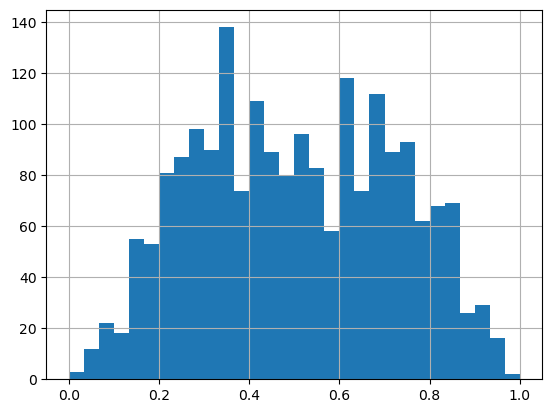

In [9]:
# mean-of-means and distribution-of-means
print(df.groupby("tweet_id_comment_nr")['comment_inhoudelijk_argument_binary'].agg('mean').describe())
df.groupby("tweet_id_comment_nr")['comment_inhoudelijk_argument_binary'].agg("mean").hist(bins=30)

### Tabels with illustrations

In [10]:
print(list(dfagg[dfagg['tweet_id_comment_nr'] == '22_1'].text)[0])
print()
print(df[df['tweet_id_comment_nr'] == '22_1']['comment_inhoudelijk_argument_binary'].value_counts())
print(df[df['tweet_id_comment_nr'] == '22_1']['comment_inhoudelijk_argument_binary'].value_counts(normalize=True))

@USER Men riep hier jaren te schreeuwen over 'global warming' tot de strenge winters kwamen. Toen werd het ineens 'klimaatverandering'. Het mooie van dat laatste is, is het een warme dag, het komt door klimaatverandering. Is het een koude dag, het komt door klimaatverandering.

comment_inhoudelijk_argument_binary
0    13
1    11
Name: count, dtype: int64
comment_inhoudelijk_argument_binary
0    0.541667
1    0.458333
Name: proportion, dtype: float64


In [11]:
print(list(dfagg[dfagg['tweet_id_comment_nr'] == '15_5'].text)[0])
print()
print(df[df['tweet_id_comment_nr'] == '15_5']['comment_inhoudelijk_argument_binary'].value_counts())
print(df[df['tweet_id_comment_nr'] == '15_5']['comment_inhoudelijk_argument_binary'].value_counts(normalize=True))

@USER Shells belangen én daden staan 𝗹𝗶𝗻𝗲𝗮 𝗿𝗲𝗰𝘁𝗮 tegenover de belangen van de rest van de wereld. Dat valt niet te ontkennen.

Waarom dan Shell ophemelen voor deze minimale inzet om hun imago op te schonen?

comment_inhoudelijk_argument_binary
1    13
0     8
Name: count, dtype: int64
comment_inhoudelijk_argument_binary
1    0.619048
0    0.380952
Name: proportion, dtype: float64


In [15]:
for i in ['78_1','78_2','78_3','78_4','78_5']:
    print(i)
    print(list(dfagg[dfagg['tweet_id_comment_nr'] == str(i)].text)[0])
    print(df[df['tweet_id_comment_nr'] == str(i)]['comment_inhoudelijk_argument_binary'].value_counts())
    print(df[df['tweet_id_comment_nr'] == str(i)]['comment_inhoudelijk_argument_binary'].mean())
    print()

78_1
@USER (Terecht)
comment_inhoudelijk_argument_binary
0    13
1     6
Name: count, dtype: int64
0.3157894736842105

78_2
@USER Zin om er nog eentje te maken, ditmaal met ketjap
comment_inhoudelijk_argument_binary
0    11
1     8
Name: count, dtype: int64
0.42105263157894735

78_3
@USER en stukjes kipfilet: kipsaté
comment_inhoudelijk_argument_binary
0    11
1     8
Name: count, dtype: int64
0.42105263157894735

78_4
@USER https://t.co/OwwWKJxUb0
comment_inhoudelijk_argument_binary
0    15
1     4
Name: count, dtype: int64
0.21052631578947367

78_5
@USER Hahahaha jokes on you: ze heeft me niet laten vallen, maar alleen gerookt en gedronken tijdens zwangerschap. Heb je niet van terug hè
comment_inhoudelijk_argument_binary
1    11
0     8
Name: count, dtype: int64
0.5789473684210527



## Section 3.2: To what extent are the conversations perceived as civil? 

In [18]:
# majority vote
dfagg['comment_persoonlijke_aanval'].value_counts(normalize=True)

comment_persoonlijke_aanval
Geen persoonlijke aanval    0.772455
Persoonlijke aanval         0.227545
Name: proportion, dtype: float64

In [22]:
print(df['comment_persoonlijke_aanval'].value_counts(normalize=True))
print(df['comment_persoonlijke_aanval'].value_counts(normalize=False))
print(df['comment_persoonlijke_aanval'].count())

comment_persoonlijke_aanval
Geen persoonlijke aanval    0.629169
Persoonlijke aanval         0.370831
Name: proportion, dtype: float64
comment_persoonlijke_aanval
Geen persoonlijke aanval    26729
Persoonlijke aanval         15754
Name: count, dtype: int64
42483


count    2004.000000
mean        0.370123
std         0.199598
min         0.000000
25%         0.222222
50%         0.333333
75%         0.480000
max         1.000000
Name: comment_persoonlijke_aanval_binary, dtype: float64


<AxesSubplot: >

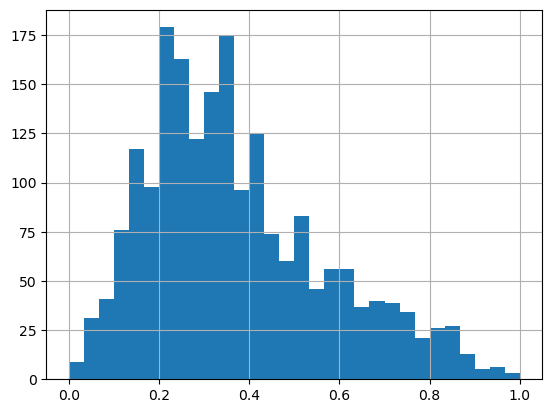

In [20]:
# mean-of-means and distribution-of-means
print(df.groupby("tweet_id_comment_nr")['comment_persoonlijke_aanval_binary'].agg('mean').describe())
df.groupby("tweet_id_comment_nr")['comment_persoonlijke_aanval_binary'].agg("mean").hist(bins=30)

### Tabel with examples

In [18]:
for i in ['19_1','19_2','19_3', '19_4', '19_5']:
    print(i)
    print(list(dfagg[dfagg['tweet_id_comment_nr'] == str(i)].text)[0])
    print(df[df['tweet_id_comment_nr'] == str(i)]['comment_persoonlijke_aanval_binary'].value_counts())
    print(df[df['tweet_id_comment_nr'] == str(i)]['comment_persoonlijke_aanval_binary'].mean())
    print()

19_1
@USER @USER @USER Is natuurlijk wel een heel beperkt beeld. Het gaat natuurlijk om de gevolgen van klimaatverandering die echt gevaarlijk zijn. Maar dat begrijp je zelf ook wel.
comment_persoonlijke_aanval_binary
1    13
0     8
Name: count, dtype: int64
0.6190476190476191

19_2
@USER @USER @USER Welke zijn dat? En dan niet lokaal invullen. Maar kijk globaal. Complete cijfers die echt stijgen. Dus niet de 'mogelijke', of 'misschien' modelcijfers.
comment_persoonlijke_aanval_binary
1    11
0    11
Name: count, dtype: int64
0.5

19_3
@USER @USER @USER Even voor mijn duidelijkheid. Wat betwist je precies? De menselijke invloed op klimaatverandering of de schadelijke effecten hiervan? Bijvoorbeeld op biodiversiteit. 

https://t.co/P8BbnNUFKs
comment_persoonlijke_aanval_binary
1    16
0     6
Name: count, dtype: int64
0.7272727272727273

19_4
@USER @USER @USER Biodiversiteit hangt samen met hoeveelheid habitat en de verbindingen ertussen, plus ons milieu. Extremen zijn er altijd op aar

## Section 3.3: To what extent are the conversations perceived as respectful? 

In [22]:
# majority vote
print(dfagg['comment_respectvol'].value_counts(normalize=True))
print(dfagg['comment_respectvol'].count())

comment_respectvol
Eens      0.836826
Oneens    0.163174
Name: proportion, dtype: float64
2004


In [20]:
print(df['comment_respectvol'].value_counts(normalize=True))
print(df['comment_respectvol'].value_counts(normalize=False))
print(df['comment_respectvol'].count())

comment_respectvol
Eens      0.687004
Oneens    0.312996
Name: proportion, dtype: float64
comment_respectvol
Eens      29186
Oneens    13297
Name: count, dtype: int64
42483


count    2004.000000
mean        0.687494
std         0.192605
min         0.047619
25%         0.571429
50%         0.727273
75%         0.833333
max         1.000000
Name: comment_respectvol_binary, dtype: float64


<AxesSubplot: >

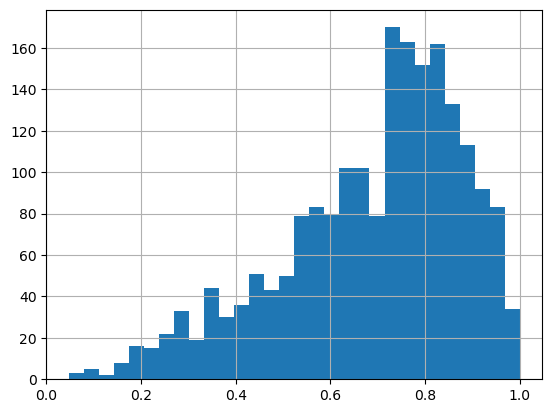

In [21]:
# mean-of-means and distribution-of-means
print(df.groupby("tweet_id_comment_nr")['comment_respectvol_binary'].agg('mean').describe())
df.groupby("tweet_id_comment_nr")['comment_respectvol_binary'].agg("mean").hist(bins=30)

In [23]:
pd.crosstab(df['comment_persoonlijke_aanval_binary'], df['comment_respectvol_binary'])

comment_respectvol_binary,0,1
comment_persoonlijke_aanval_binary,,
0,6008,20721
1,7289,8465


## Section 3.4: Explaining the differences

In [15]:
# simple logit to start
_tmp = df.copy()
_tmp = _tmp[_tmp.gender.isin(['Vrouw','Man'])]  # sorry, exclude the very few non binary people
smf.logit("comment_inhoudelijk_argument_binary ~ 1+ age + gender + higher_education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat", 
          _tmp).fit().summary()



Optimization terminated successfully.
         Current function value: 0.688501
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Logit Regression Results                                   
===============================================================================================
Dep. Variable:     comment_inhoudelijk_argument_binary   No. Observations:                42192
Model:                                           Logit   Df Residuals:                    42184
Method:                                            MLE   Df Model:                            7
Date:                                  wo, 08 jan 2025   Pseudo R-squ.:                0.006698
Time:                                         22:16:56   Log-Likelihood:                -29049.
converged:                                        True   LL-Null:                       -29245.
Covariance Type:                             nonrobust   LLR p-value:                 1.384e-80
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -0.1506      0.055     -2.753      0.006      -0.258      -0.043
gender[T.Vrouw]                              -0.0337      0.020     -1.699      0.089      -0.073       0.005
age                                           0.0006      0.001      0.949      0.343      -0.001       0.002
higher_education                             -0.3065      0.020    -15.005      0.000      -0.347      -0.266
scientific_consensus_pro_klimaat             -0.0072      0.011     -0.680      0.497      -0.028       0.014
scientific_consensus_belangrijk_onderwerp    -0.0582      0.012     -4.911      0.000      -0.081      -0.035
scientific_consensus_sterke_mening            0.0450      0.009      5.173      0.000       0.028       0.062
scientific_consensus_interesse_klimaat        0.0814      0.010      8.167      0.000       0.062       0.101
=============================================================================================================
"""

In [17]:
#ultimately, mixed effects
m1 = Lmer("comment_inhoudelijk_argument_binary ~ 1+ age + gender + higher_education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat"
         " + (1 | tweet_id_comment_nr) ", 
          _tmp, family='binomial').fit()
m1

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: comment_inhoudelijk_argument_binary~1+age+gender+higher_education+scientific_consensus_pro_klimaat+scientific_consensus_belangrijk_onderwerp+scientific_consensus_sterke_mening+scientific_consensus_interesse_klimaat+(1|tweet_id_comment_nr)

Family: binomial	 Inference: parametric

Number of observations: 42192	 Groups: {'tweet_id_comment_nr': 2004.0}

Log-likelihood: -27082.062 	 AIC: 54182.123

Random effects:

                            Name    Var    Std
tweet_id_comment_nr  (Intercept)  0.844  0.919

No random effect correlations specified

Fixed effects:



/home/damian/.local/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.136,-0.260,-0.011,0.064,0.873,0.771,0.989,0.466,0.435,0.497,-2.132,0.033,*
age,-0.000,-0.001,0.001,0.001,1.000,0.999,1.001,0.500,0.500,0.500,-0.100,0.920,
genderVrouw,-0.029,-0.072,0.014,0.022,0.972,0.931,1.014,0.493,0.482,0.504,-1.308,0.191,
higher_education,-0.353,-0.398,-0.309,0.023,0.702,0.672,0.734,0.413,0.402,0.423,-15.683,0.000,***
scientific_consensus_pro_klimaat,-0.013,-0.036,0.010,0.012,0.987,0.965,1.010,0.497,0.491,0.502,-1.128,0.259,
scientific_consensus_belangrijk_onderwerp,-0.074,-0.099,-0.048,0.013,0.929,0.905,0.953,0.482,0.475,0.488,-5.630,0.000,***
scientific_consensus_sterke_mening,0.061,0.043,0.080,0.010,1.063,1.044,1.084,0.515,0.511,0.520,6.401,0.000,***
scientific_consensus_interesse_klimaat,0.096,0.075,0.118,0.011,1.101,1.078,1.125,0.524,0.519,0.529,8.780,0.000,***


In [21]:
smf.logit("comment_persoonlijke_aanval_binary ~ 1+ age + gender + higher_education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat", 
          _tmp).fit().summary()


Optimization terminated successfully.
         Current function value: 0.646041
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Logit Regression Results                                   
==============================================================================================
Dep. Variable:     comment_persoonlijke_aanval_binary   No. Observations:                42192
Model:                                          Logit   Df Residuals:                    42184
Method:                                           MLE   Df Model:                            7
Date:                                 wo, 08 jan 2025   Pseudo R-squ.:                 0.01926
Time:                                        22:24:00   Log-Likelihood:                -27258.
converged:                                       True   LL-Null:                       -27793.
Covariance Type:                            nonrobust   LLR p-value:                6.874e-227
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -0.4888      0.057     -8.553      0.000      -0.601      -0.377
gender[T.Vrouw]                              -0.0099      0.021     -0.479      0.632      -0.050       0.031
age                                          -0.0068      0.001    -10.774      0.000      -0.008      -0.006
higher_education                             -0.3494      0.021    -16.296      0.000      -0.391      -0.307
scientific_consensus_pro_klimaat              0.0345      0.011      3.120      0.002       0.013       0.056
scientific_consensus_belangrijk_onderwerp    -0.1749      0.012    -14.036      0.000      -0.199      -0.150
scientific_consensus_sterke_mening            0.0468      0.009      5.093      0.000       0.029       0.065
scientific_consensus_interesse_klimaat        0.1995      0.011     18.735      0.000       0.179       0.220
=============================================================================================================
"""

In [18]:
m2 = Lmer("comment_persoonlijke_aanval_binary ~ 1+ age + gender + higher_education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat"
         " + (1 | tweet_id_comment_nr) ", 
          _tmp, family='binomial').fit()
m2

[1] "Model failed to converge with max|grad| = 0.24947 (tol = 0.002, component 1)"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: comment_persoonlijke_aanval_binary~1+age+gender+higher_education+scientific_consensus_pro_klimaat+scientific_consensus_belangrijk_onderwerp+scientific_consensus_sterke_mening+scientific_consensus_interesse_klimaat+(1|tweet_id_comment_nr)

Family: binomial	 Inference: parametric

Number of observations: 42192	 Groups: {'tweet_id_comment_nr': 2004.0}

Log-likelihood: -25729.245 	 AIC: 51476.489

Random effects:

                            Name    Var    Std
tweet_id_comment_nr  (Intercept)  0.712  0.844

No random effect correlations specified

Fixed effects:



/home/damian/.local/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.596,-0.723,-0.469,0.065,0.551,0.485,0.625,0.355,0.327,0.385,-9.205,0.000,***
age,-0.007,-0.009,-0.006,0.001,0.993,0.991,0.994,0.498,0.498,0.498,-10.717,0.000,***
genderVrouw,-0.035,-0.079,0.010,0.023,0.966,0.924,1.010,0.491,0.480,0.502,-1.538,0.124,
higher_education,-0.384,-0.429,-0.338,0.023,0.681,0.651,0.713,0.405,0.394,0.416,-16.466,0.000,***
scientific_consensus_pro_klimaat,0.047,0.023,0.070,0.012,1.048,1.024,1.073,0.512,0.506,0.518,3.898,0.000,***
scientific_consensus_belangrijk_onderwerp,-0.195,-0.222,-0.169,0.014,0.823,0.801,0.845,0.451,0.445,0.458,-14.334,0.000,***
scientific_consensus_sterke_mening,0.051,0.032,0.071,0.010,1.053,1.032,1.073,0.513,0.508,0.518,5.150,0.000,***
scientific_consensus_interesse_klimaat,0.222,0.199,0.244,0.012,1.248,1.221,1.277,0.555,0.550,0.561,19.248,0.000,***


In [22]:
smf.logit("comment_respectvol_binary ~ 1+ age + gender + higher_education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat", 
          _tmp).fit().summary()


Optimization terminated successfully.
         Current function value: 0.619592
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     comment_respectvol_binary   No. Observations:                42192
Model:                                 Logit   Df Residuals:                    42184
Method:                                  MLE   Df Model:                            7
Date:                        wo, 08 jan 2025   Pseudo R-squ.:                0.002466
Time:                               22:24:18   Log-Likelihood:                -26142.
converged:                              True   LL-Null:                       -26206.
Covariance Type:                   nonrobust   LLR p-value:                 8.975e-25
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.4303      0.058      7.426      0.000       0.317       0.544
gender[T.Vrouw]                              -0.0726      0.021     -3.403      0.001      -0.114      -0.031
age                                          -0.0005      0.001     -0.710      0.477      -0.002       0.001
higher_education                              0.1113      0.022      5.052      0.000       0.068       0.155
scientific_consensus_pro_klimaat              0.0184      0.011      1.631      0.103      -0.004       0.041
scientific_consensus_belangrijk_onderwerp     0.0524      0.013      4.145      0.000       0.028       0.077
scientific_consensus_sterke_mening            0.0394      0.009      4.251      0.000       0.021       0.058
scientific_consensus_interesse_klimaat       -0.0451      0.011     -4.219      0.000      -0.066      -0.024
=============================================================================================================
"""

In [19]:
m3 = Lmer("comment_respectvol_binary ~ 1+ age + gender + higher_education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat"
         " + (1 | tweet_id_comment_nr) ", 
          _tmp, family='binomial').fit()
m3

[1] "Model failed to converge with max|grad| = 0.0109557 (tol = 0.002, component 1)"
[2] " \n"                                                                           

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: comment_respectvol_binary~1+age+gender+higher_education+scientific_consensus_pro_klimaat+scientific_consensus_belangrijk_onderwerp+scientific_consensus_sterke_mening+scientific_consensus_interesse_klimaat+(1|tweet_id_comment_nr)

Family: binomial	 Inference: parametric

Number of observations: 42192	 Groups: {'tweet_id_comment_nr': 2004.0}

Log-likelihood: -24673.995 	 AIC: 49365.990

Random effects:

                            Name    Var    Std
tweet_id_comment_nr  (Intercept)  0.734  0.857

No random effect correlations specified

Fixed effects:



/home/damian/.local/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.586,0.457,0.714,0.065,1.796,1.580,2.042,0.642,0.612,0.671,8.942,0.000,***
age,-0.001,-0.003,-0.000,0.001,0.999,0.997,1.000,0.500,0.499,0.500,-2.118,0.034,*
genderVrouw,-0.078,-0.123,-0.032,0.023,0.925,0.884,0.968,0.481,0.469,0.492,-3.350,0.001,***
higher_education,0.113,0.067,0.160,0.024,1.120,1.069,1.174,0.528,0.517,0.540,4.761,0.000,***
scientific_consensus_pro_klimaat,0.013,-0.011,0.037,0.012,1.013,0.989,1.038,0.503,0.497,0.509,1.092,0.275,
scientific_consensus_belangrijk_onderwerp,0.050,0.023,0.077,0.014,1.051,1.023,1.080,0.513,0.506,0.519,3.644,0.000,***
scientific_consensus_sterke_mening,0.046,0.027,0.066,0.010,1.048,1.027,1.068,0.512,0.507,0.517,4.615,0.000,***
scientific_consensus_interesse_klimaat,-0.041,-0.063,-0.018,0.012,0.960,0.939,0.982,0.490,0.484,0.496,-3.520,0.000,***


# SCRATCH

In [13]:
dfagg['comment_inhoudelijk_argument'].value_counts()

comment_inhoudelijk_argument
Geen inhoudelijk argument    1053
Inhoudelijk argument          951
Name: count, dtype: int64

In [35]:
# let's make a binary recode
def customrecode(x):
    if 'geen' in x.lower():
        return False
    elif 'oneens' in x.lower():
        return False
    else:
        return True
dfagg.iloc[:,4:-1] = dfagg.iloc[:,4:-1].applymap(customrecode)

/tmp/ipykernel_176261/3498418064.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfagg.iloc[:,4:-1] = dfagg.iloc[:,4:-1].applymap(customrecode)


AttributeError: 'float' object has no attribute 'lower'

## Diagnostics - slaan de coderingen ergens op?

In [15]:
for e in dfagg.query('comment_over_communicatie==True')['text']:
    print(e)

@USER @USER @USER @USER Ja het wordt steeds kouder.
Hoe kan dat?
@USER @USER @USER @USER Omdat het steeds warmer wordt!
@USER @USER @USER @USER Nou ik kan me niet herinneren dat ik ooit in augustus kachel aan had, dan nu
@USER @USER @USER @USER Ik zou het huis maar eens isoleren en deuren dicht! Ik woon veelal in Nederland, onze verwarming brandt niet!
@USER @USER @USER @USER Ja jij zat vast op Ibiza.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
@USER Écht Michel? Dus als die natuur - inderdaad door andere oorzaken - al in zeer slechte staat verkeert, dan moet je die niet ontzien en gewoon verder aantasten? Want die molens moeten per se op die 15% van ons landoppervlak in plaats van elders?
@USER Elders kan niet. Zee is al vol. Dus: ja. Dat ontkennen is jezelf voor de gek houden. Er is geen keuze.
@USER Dus de zee en de natuur zijn de plekken waar de opwek plaats moet vinden voor de onverminderd exorbitante energievraag van de industrie/economie/huishoudens. Nou, gelukkig denkt 

In [16]:
for e in dfagg[dfagg['comment_inhoudelijk_argument']==True]['text']:
    print(e)
    print()

@USER @USER @USER @USER Omdat het steeds warmer wordt!

@USER @USER @USER @USER Ik zou het huis maar eens isoleren en deuren dicht! Ik woon veelal in Nederland, onze verwarming brandt niet!

nan

nan

nan

nan

nan

@USER Écht Michel? Dus als die natuur - inderdaad door andere oorzaken - al in zeer slechte staat verkeert, dan moet je die niet ontzien en gewoon verder aantasten? Want die molens moeten per se op die 15% van ons landoppervlak in plaats van elders?

@USER Elders kan niet. Zee is al vol. Dus: ja. Dat ontkennen is jezelf voor de gek houden. Er is geen keuze.

@USER Dus de zee en de natuur zijn de plekken waar de opwek plaats moet vinden voor de onverminderd exorbitante energievraag van de industrie/economie/huishoudens. Nou, gelukkig denkt niet iedereen er zo over.

@USER We je feiten weten voor je uitspraken doet. 1: Ik heb niet gezegd dat er geen energie bezuinigd moet worden. Dat moet wel, ongeveer 50%. Maar dan nog is de opgave gigantisch en is er op zee geen ruimte voor

In [17]:
dfagg['comment_persoonlijke_aanval'].value_counts(normalize=True)
dfagg['comment_persoonlijke_aanval'].value_counts(normalize=False)

comment_persoonlijke_aanval
False    1544
True      460
Name: count, dtype: int64

In [18]:
for e in dfagg[dfagg['comment_persoonlijke_aanval']==True]['text']:
    print(e)
    print()

@USER @USER @USER @USER Ik zou het huis maar eens isoleren en deuren dicht! Ik woon veelal in Nederland, onze verwarming brandt niet!

@USER @USER @USER @USER Ja jij zat vast op Ibiza.

nan

nan

nan

nan

nan

nan

nan

@USER Écht Michel? Dus als die natuur - inderdaad door andere oorzaken - al in zeer slechte staat verkeert, dan moet je die niet ontzien en gewoon verder aantasten? Want die molens moeten per se op die 15% van ons landoppervlak in plaats van elders?

@USER Dus de zee en de natuur zijn de plekken waar de opwek plaats moet vinden voor de onverminderd exorbitante energievraag van de industrie/economie/huishoudens. Nou, gelukkig denkt niet iedereen er zo over.

@USER 2: Ik heb niet gezegd dat er persé opwek in natuur plaats moet vinden. Wel dat voorbarige protest van natuurorganisaties teken is dat zij prioriteiten verkeerd hebben. Door alleen te kijken naar korte termijn belang van bedreigde natuur zien ze niet de vloedgolf die er aan komt.

@USER Als jullie nog banen zoe

In [19]:
dfagg['comment_respectvol'].value_counts(normalize=True)
dfagg['comment_respectvol'].value_counts(normalize=False)

comment_respectvol
True     1676
False     328
Name: count, dtype: int64

In [20]:
for e in dfagg[dfagg['comment_respectvol']==False]['text']:
    print(e)
    print()

@USER @USER @USER @USER Ja jij zat vast op Ibiza.

nan

nan

nan

nan

nan

nan

nan

@USER Als jullie nog banen zoeken. Er ligt nog een berg kerstboom afval en een stuk gereden stoep bij mij om de hoek( Volendamlaan)Doe daar eerst wat aan

nan

nan

@USER Hij praat trouwens onzin want ik heb hier tig mezen in de tuin, er komt trouwens net een merel buurten.

@USER Ohjee...als de capslock's van stal worden worden gehaald, dan weten we dat het menens is...

@USER Wat is de boodschap, je hebt moeite met slikken? Wat heeft dat nou weer met klimaatverandering te maken?

@USER Wat heeft jou opmerking m.b.t. "caps" met  klimaatverandering te maken?

#klimaatzaak #Klimaatzaakshell #klimaatGEKTE

@USER Enig spoor van argumentatie ontbreekt volledig in jou tweet over #klimaatGEKTE . Dat past in een lange traditie van randdebielen op het internet die denken dat ze met capslock hun standpunt kracht bij te zetten. Terwijl ze gewoon geen idee hebben van wat er speelt.

@USER #klimaatGEK(TE) https:/

In [21]:
for e in dfagg.query('comment_respectvol==False and comment_persoonlijke_aanval==True')['text']:
    print(e)
    print()

@USER @USER @USER @USER Ja jij zat vast op Ibiza.

nan

nan

nan

nan

nan

nan

nan

@USER Als jullie nog banen zoeken. Er ligt nog een berg kerstboom afval en een stuk gereden stoep bij mij om de hoek( Volendamlaan)Doe daar eerst wat aan

nan

@USER Hij praat trouwens onzin want ik heb hier tig mezen in de tuin, er komt trouwens net een merel buurten.

@USER Ohjee...als de capslock's van stal worden worden gehaald, dan weten we dat het menens is...

@USER Wat is de boodschap, je hebt moeite met slikken? Wat heeft dat nou weer met klimaatverandering te maken?

@USER Wat heeft jou opmerking m.b.t. "caps" met  klimaatverandering te maken?

#klimaatzaak #Klimaatzaakshell #klimaatGEKTE

@USER Enig spoor van argumentatie ontbreekt volledig in jou tweet over #klimaatGEKTE . Dat past in een lange traditie van randdebielen op het internet die denken dat ze met capslock hun standpunt kracht bij te zetten. Terwijl ze gewoon geen idee hebben van wat er speelt.

nan

nan

nan

@USER Je wilt luiev

In [22]:
dfagg.query('comment_respectvol==False and comment_persoonlijke_aanval==True')['text']

4       @USER @USER @USER @USER Ja jij zat vast op Ibiza.
10                                                    NaN
11                                                    NaN
13                                                    NaN
14                                                    NaN
                              ...                        
1993                                              @USER 😂
1994    @USER Ook als je denkt dat de klimaatopwarming...
2001       @USER Triest hè. Maar goed een ouwe witte man.
2002    @USER Supertriest. En ik ben te dom om dat te ...
2003             @USER Ach de man mag stukkies schrijven.
Name: text, Length: 260, dtype: object

In [23]:
dfagg.query('comment_persoonlijke_aanval==True')['text']

3       @USER @USER @USER @USER Ik zou het huis maar e...
4       @USER @USER @USER @USER Ja jij zat vast op Ibiza.
10                                                    NaN
11                                                    NaN
13                                                    NaN
                              ...                        
1993                                              @USER 😂
1994    @USER Ook als je denkt dat de klimaatopwarming...
2001       @USER Triest hè. Maar goed een ouwe witte man.
2002    @USER Supertriest. En ik ben te dom om dat te ...
2003             @USER Ach de man mag stukkies schrijven.
Name: text, Length: 460, dtype: object

In [24]:
dfagg.query('comment_respectvol==True and comment_persoonlijke_aanval==True')['text']

3       @USER @USER @USER @USER Ik zou het huis maar e...
18      @USER Écht Michel? Dus als die natuur - inderd...
20      @USER Dus de zee en de natuur zijn de plekken ...
22      @USER 2: Ik heb niet gezegd dat er persé opwek...
36      @USER Nee John. Er is wel degelijk een klimaat...
                              ...                        
1943                                                  NaN
1948    @USER Er is inderdaad zoveel nep en vals in de...
1960                                                  NaN
1983                                                  NaN
1989                                  @USER Je bent mild😁
Name: text, Length: 200, dtype: object

# TODO analyses

In [26]:
# verder met issue framing en polarization
dfagg['comment_inhoudelijk_argument']  # issue framing  (True)
dfagg['comment_respectvol']   # polarization frame (False)

# testen als volgt:
# 1) verandert de kans dat de *volgende* comments inhoudelijk zijn als er een niet-respectvolle comment geplaatst wordt?
# 2) hetzelfde andersom

# alsnog de clusteranalyse runnen

0        True
1        True
2        True
3        True
4       False
        ...  
1999     True
2000    False
2001    False
2002    False
2003    False
Name: comment_respectvol, Length: 2004, dtype: object

# Stap 1: Descriptives

In [9]:
dvs = ['comment_pro_klimaat', 'comment_inhoudelijk_argument',
       'comment_persoonlijke_aanval', 'comment_over_communicatie', 'comment_respectvol']

for dv in dvs:
    print(df[dv].value_counts(normalize=True))
    print()

comment_pro_klimaat
Nee         0.356013
Ja          0.351554
Neutraal    0.292433
Name: proportion, dtype: float64

comment_inhoudelijk_argument
Geen inhoudelijk argument    0.50014
Inhoudelijk argument         0.49986
Name: proportion, dtype: float64

comment_persoonlijke_aanval
Geen persoonlijke aanval    0.628466
Persoonlijke aanval         0.371534
Name: proportion, dtype: float64

comment_over_communicatie
Eens      0.540379
Oneens    0.459621
Name: proportion, dtype: float64

comment_respectvol
Eens      0.686874
Oneens    0.313126
Name: proportion, dtype: float64



<AxesSubplot: >

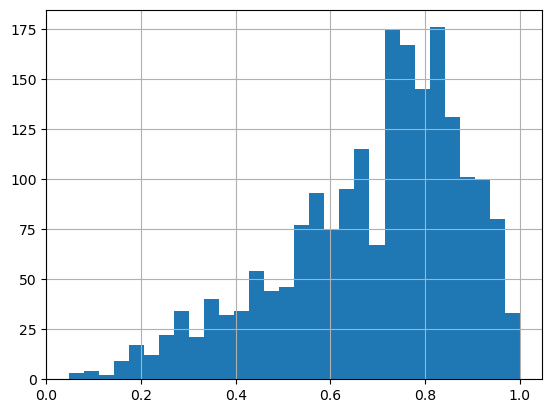

In [274]:
df.groupby("tweed_id_comment_nr")['comment_respectvol_binary'].agg("mean").hist(bins=30)

In [ ]:
high_disagreement = df.groupby("tweed_id_comment_nr")['comment_inhoudelijk_argument_binary'].mean().map(lambda x: .3 < x < .7)

In [184]:
high_disagreement = df.groupby("tweed_id_comment_nr")['comment_inhoudelijk_argument_binary'].mean().map(lambda x: .3 < x < .7)
high_disagreement.name = "high_disagreement"
dfagg['tweed_id_comment_nr'] = dfagg['tweet_id'].map(str) + dfagg['comment_nr'].map(str)
tmp = dfagg.join(high_disagreement, on="tweed_id_comment_nr")
for l in tmp[tmp['high_disagreement']==True].loc[:,['text','tweed_id_comment_nr']].iterrows():
    print(l[1].tweed_id_comment_nr, l[1].text)
    print()


11 @USER @USER @USER @USER Ja het wordt steeds kouder.
Hoe kan dat?

12 @USER @USER @USER @USER Omdat het steeds warmer wordt!

13 @USER @USER @USER @USER Nou ik kan me niet herinneren dat ik ooit in augustus kachel aan had, dan nu

14 @USER @USER @USER @USER Ik zou het huis maar eens isoleren en deuren dicht! Ik woon veelal in Nederland, onze verwarming brandt niet!

21 nan

22 nan

31 nan

32 nan

34 nan

35 nan

36 nan

37 nan

38 nan

42 @USER Elders kan niet. Zee is al vol. Dus: ja. Dat ontkennen is jezelf voor de gek houden. Er is geen keuze.

47 @USER 4: Dat zelfs binnen @USER mensen vanuit deelbelangen of eigenbelang hun ogen sluiten voor de opgave waar we voor staan is voor mij de belangrijkste reden geweest dat ik het niet meer kon opbrengen om daar nog energie in te steken. Ik heb wel wat beters te doen.

51 @USER Klimaatcrisis geef ik de voorkeur aan🤔

52 @USER Inderdaad meer een crisis en gekmakend.
Ik heb zeer weinig vertrouwen in de politiek wat betreft dit mega-probleem

56    @USER Men riep hier jaren te schreeuwen over '...
Name: text, dtype: object
comment_inhoudelijk_argument_binary
0    13
1    11
Name: count, dtype: int64


In [218]:
print(str(dfagg[dfagg['tweed_id_comment_nr'] == '151'].text))
print(df[df['tweed_id_comment_nr'] == '151']['comment_inhoudelijk_argument_binary'].value_counts())
print(df[df['tweed_id_comment_nr'] == '151']['comment_inhoudelijk_argument_binary'].mean())

41    @USER Dit is hoe GroenLinks denkt. Ik vind dat...
Name: text, dtype: object
comment_inhoudelijk_argument_binary
0    12
1     9
Name: count, dtype: int64
0.42857142857142855


In [221]:
for i in range(781, 785):
    print(str(dfagg[dfagg['tweed_id_comment_nr'] == str(i)].text))
    print(df[df['tweed_id_comment_nr'] == str(i)]['comment_inhoudelijk_argument_binary'].value_counts())
    print(df[df['tweed_id_comment_nr'] == str(i)]['comment_inhoudelijk_argument_binary'].mean())
    print()

228    @USER (Terecht)
Name: text, dtype: object
comment_inhoudelijk_argument_binary
0    13
1     6
Name: count, dtype: int64
0.3157894736842105

229    @USER Zin om er nog eentje te maken, ditmaal m...
Name: text, dtype: object
comment_inhoudelijk_argument_binary
0    11
1     8
Name: count, dtype: int64
0.42105263157894735

230    @USER en stukjes kipfilet: kipsaté
Name: text, dtype: object
comment_inhoudelijk_argument_binary
0    11
1     8
Name: count, dtype: int64
0.42105263157894735

231    @USER https://t.co/OwwWKJxUb0
Name: text, dtype: object
comment_inhoudelijk_argument_binary
0    15
1     4
Name: count, dtype: int64
0.21052631578947367



In [260]:
print(str(dfagg[dfagg['tweed_id_comment_nr'] == '14'].text))
print(df[df['tweed_id_comment_nr'] == '14']['comment_persoonlijke_aanval_binary'].value_counts())
print(df[df['tweed_id_comment_nr'] == '14']['comment_persoonlijke_aanval_binary'].mean())

3    @USER @USER @USER @USER Ik zou het huis maar e...
Name: text, dtype: object
comment_persoonlijke_aanval_binary
1    25
0    23
Name: count, dtype: int64
0.5208333333333334


In [269]:
"""9,0,"@USER @USER @USER Alles wordt beter in realiteit😊. Onze nieuwsvoorziening is alleen sneller en beter.

Uitgebreide data hier: https://t.co/ylXeT03qMU https://t.co/G6vm5qllAT"
19,1,@USER @USER @USER Is natuurlijk wel een heel beperkt beeld. Het gaat natuurlijk om de gevolgen van klimaatverandering die echt gevaarlijk zijn. Maar dat begrijp je zelf ook wel.
19,2,"@USER @USER @USER Welke zijn dat? En dan niet lokaal invullen. Maar kijk globaal. Complete cijfers die echt stijgen. Dus niet de 'mogelijke', of 'misschien' modelcijfers."
19,3,"@USER @USER @USER Even voor mijn duidelijkheid. Wat betwist je precies? De menselijke invloed op klimaatverandering of de schadelijke effecten hiervan? Bijvoorbeeld op biodiversiteit. 

https://t.co/P8BbnNUFKs"
19,4,"@USER @USER @USER Biodiversiteit hangt samen met hoeveelheid habitat en de verbindingen ertussen, plus ons milieu. Extremen zijn er altijd op aarde en schommelingen in populatiegrootte zijn op te vangen door uitwijkmogelijkheden. De probleem zit hem dus niet in 't klimaat of bepaalde weerstypes."
19,5,@USER @USER @USER Snelle klimaatverandering kan natuurlijk wel een probleem zijn omdat het een ecosystemen veranderd. Door de snelheid kunnen ze zich niet aanpassen. Soorten in koudere gebieden hebben beperkte uitwijkmogelijkheden. Ben met je eens dat hoeveelheid habitat ernstig tekort schiet."""


for i in range(191, 197):
    print(i)
    print(str(dfagg[dfagg['tweed_id_comment_nr'] == str(i)].text))
    print(df[df['tweed_id_comment_nr'] == str(i)]['comment_persoonlijke_aanval_binary'].value_counts())
    print(df[df['tweed_id_comment_nr'] == str(i)]['comment_persoonlijke_aanval_binary'].mean())
    print()

191
51    NaN
Name: text, dtype: object
comment_persoonlijke_aanval_binary
1    13
0     8
Name: count, dtype: int64
0.6190476190476191

192
52    NaN
Name: text, dtype: object
comment_persoonlijke_aanval_binary
1    11
0    11
Name: count, dtype: int64
0.5

193
53    NaN
Name: text, dtype: object
comment_persoonlijke_aanval_binary
1    16
0     6
Name: count, dtype: int64
0.7272727272727273

194
54    NaN
Name: text, dtype: object
comment_persoonlijke_aanval_binary
0    13
1     9
Name: count, dtype: int64
0.4090909090909091

195
55    NaN
Name: text, dtype: object
comment_persoonlijke_aanval_binary
1    11
0    11
Name: count, dtype: int64
0.5

196
Series([], Name: text, dtype: object)
Series([], Name: count, dtype: int64)
nan



In [204]:
_tmp2 = df[df['tweed_id_comment_nr'] == '221']
pd.crosstab(_tmp2['comment_inhoudelijk_argument'], _tmp2['comment_pro_klimaat'])

comment_pro_klimaat,Ja,Nee,Neutraal
comment_inhoudelijk_argument,,,
Geen inhoudelijk argument,2,7,4
Inhoudelijk argument,4,5,2


In [205]:
# cientific_consensus_pro_klimaat 	scientific_consensus_belangrijk_onderwerp 	scientific_consensus_sterke_mening 	scientific_consensus_interesse_klimaat 	
pd.crosstab(_tmp2['comment_inhoudelijk_argument'], _tmp2['scientific_consensus_pro_klimaat'])

scientific_consensus_pro_klimaat,3.0,5.0,6.0,7.0
comment_inhoudelijk_argument,,,,
Geen inhoudelijk argument,1,3,6,3
Inhoudelijk argument,2,1,5,3


In [206]:
# cientific_consensus_pro_klimaat 	scientific_consensus_belangrijk_onderwerp 	scientific_consensus_sterke_mening 	scientific_consensus_interesse_klimaat 	
pd.crosstab(_tmp2['comment_inhoudelijk_argument'], _tmp2['scientific_consensus_belangrijk_onderwerp'])

scientific_consensus_belangrijk_onderwerp,4.0,5.0,6.0,7.0
comment_inhoudelijk_argument,,,,
Geen inhoudelijk argument,0,3,5,5
Inhoudelijk argument,1,3,3,4


In [173]:
tmp[tmp['high_disagreement']==True].loc[:,['text','tweed_id_comment_nr']]

,text,tweed_id_comment_nr
0,@USER @USER @USER @USER Ja het wordt steeds ko...,11
1,@USER @USER @USER @USER Omdat het steeds warme...,12
2,@USER @USER @USER @USER Nou ik kan me niet her...,13
3,@USER @USER @USER @USER Ik zou het huis maar e...,14
5,NaN,21
...,...,...
1993,@USER 😂,5926
1994,@USER Ook als je denkt dat de klimaatopwarming...,5941
1996,"@USER Het doet er niet meer toe of de huidige,...",5943
1997,@USER Of de mens de #klimaatopwarming nog zou ...,5944


In [155]:
dfagg['tweed_id_comment_nr'] = dfagg['tweet_id'].map(str) + dfagg['comment_nr'].map(str)
dfagg.join(high_disagreement, on="tweed_id_comment_nr")

,tweet_id,comment_nr,coder,comment_pro_klimaat,comment_inhoudelijk_argument,comment_persoonlijke_aanval,comment_over_communicatie,comment_respectvol,text,tweed_id_comment_nr,high_disagreement
0,1,1,1252.083333,Neutraal,False,False,True,True,@USER @USER @USER @USER Ja het wordt steeds ko...,11,True
1,1,2,1252.083333,Ja,True,False,True,True,@USER @USER @USER @USER Omdat het steeds warme...,12,True
2,1,3,1252.083333,Nee,False,False,True,True,@USER @USER @USER @USER Nou ik kan me niet her...,13,True
3,1,4,1252.083333,Ja,True,True,True,True,@USER @USER @USER @USER Ik zou het huis maar e...,14,True
4,1,5,1252.083333,Nee,False,True,True,False,@USER @USER @USER @USER Ja jij zat vast op Ibiza.,15,False
...,...,...,...,...,...,...,...,...,...,...,...
1999,595,1,1161.380952,Nee,False,False,False,True,@USER https://t.co/wsq6qzESjV,5951,True
2000,595,2,1161.380952,Neutraal,False,False,True,False,@USER 🙄,5952,False
2001,595,3,1161.380952,Nee,False,True,True,False,@USER Triest hè. Maar goed een ouwe witte man.,5953,False
2002,595,4,1161.380952,Nee,False,True,True,False,@USER Supertriest. En ik ben te dom om dat te ...,5954,False


<AxesSubplot: >

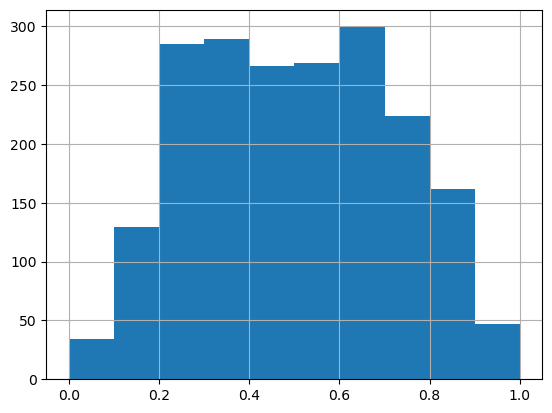

In [105]:
df.groupby("tweed_id_comment_nr")['comment_inhoudelijk_argument_bool'].agg("mean").hist()

In [64]:
df['comment_inhoudelijk_argument_binary']

0        1
1        1
2        0
3        1
4        1
        ..
42839    0
42840    0
42841    0
42842    0
42843    0
Name: comment_inhoudelijk_argument_binary, Length: 42844, dtype: int64

In [81]:
smf.logit("comment_inhoudelijk_argument_binary ~ 1+ age + gender + education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat", 
          df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.686249
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Logit Regression Results                                   
===============================================================================================
Dep. Variable:     comment_inhoudelijk_argument_binary   No. Observations:                42488
Model:                                           Logit   Df Residuals:                    42470
Method:                                            MLE   Df Model:                           17
Date:                                 Wed, 08 Jan 2025   Pseudo R-squ.:                0.009952
Time:                                         11:32:23   Log-Likelihood:                -29157.
converged:                                        True   LL-Null:                       -29450.
Covariance Type:                             nonrobust   LLR p-value:                1.189e-113
==============================================================================================================================================================================================
                                                                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                     -0.1275      0.175     -0.728      0.467      -0.471       0.216
gender[T.Non-binary]                                                                                                           0.4212      0.157      2.690      0.007       0.114       0.728
gender[T.Vrouw]                                                                                                               -0.0359      0.020     -1.801      0.072      -0.075       0.003
gender[T.Wil ik liever niet zeggen]                                                                                           -0.0988      0.210     -0.470      0.639      -0.511       0.313
education[T.Geen onderwijs of niet afgemaakt]                                                                                  0.3547      0.190      1.872      0.061      -0.017       0.726
education[T.Hoger beroepsonderwijs (HBO, HTS, HEAO, Sociale Academie, HHNO, lerarenonderwijs, etc.]                           -0.3399      0.170     -2.003      0.045      -0.673      -0.007
education[T.Lager beroepsonderwijs (LBO, LTS, LHNO, huishoud-/ambachts-school, LEAO, lage land-en tuinbouwonderwijs etc.)]     0.1589      0.173      0.920      0.358      -0.180       0.497
education[T.Lagere school (basisonderwijs)]                                                                                   -0.1165      0.199     -0.585      0.558      -0.507       0.274
education[T.Middelbaar algemeen onderwijs (LAVO, ULO, MULO, MAVO, 3-jaar HBS, etc)]                                           -0.1264      0.171     -0.737      0.461      -0.463       0.210
education[T.Middelbaar beroepsonderwijs (MBO, MTS, MEAO, Praktijkdiploma Boekhouden, Kleuterkweekschool, etc.]                -0.1694      0.170     -0.998      0.318      -0.502       0.163
education[T.Voorbereidend of kort middelbaar beroepsonderwijs (VMBO, KMBO)]                                                    0.3120      0.177      1.765      0.077      -0.034       0.658
education[T.Voortgezet algemeen onderwijs (5-jaar HBS, MMS, HAVO, Lyceum, Atheneum, Gymnasium, VWO, etc.]                     -0.1427      0.171     -0.834      0.404      -0.478       0.193
education[T.Wetenschappelijk onderwijs (universiteit)]                                                                        -0.5258      0.171     -3.071      0.002      -0.861      -0.190
age                             

In [270]:
smf.logit("comment_persoonlijke_aanval_binary ~ 1+ age + gender + education +"
          " scientific_consensus_pro_klimaat + scientific_consensus_belangrijk_onderwerp + scientific_consensus_sterke_mening + scientific_consensus_interesse_klimaat", 
          df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.643518
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Logit Regression Results                                   
==============================================================================================
Dep. Variable:     comment_persoonlijke_aanval_binary   No. Observations:                42488
Model:                                          Logit   Df Residuals:                    42470
Method:                                           MLE   Df Model:                           17
Date:                                Wed, 08 Jan 2025   Pseudo R-squ.:                 0.02410
Time:                                        15:12:11   Log-Likelihood:                -27342.
converged:                                       True   LL-Null:                       -28017.
Covariance Type:                            nonrobust   LLR p-value:                6.776e-277
==============================================================================================================================================================================================
                                                                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                     -0.2089      0.176     -1.186      0.236      -0.554       0.136
gender[T.Non-binary]                                                                                                           0.7490      0.156      4.797      0.000       0.443       1.055
gender[T.Vrouw]                                                                                                               -0.0076      0.021     -0.367      0.714      -0.048       0.033
gender[T.Wil ik liever niet zeggen]                                                                                           -0.3307      0.211     -1.567      0.117      -0.744       0.083
education[T.Geen onderwijs of niet afgemaakt]                                                                                  0.1372      0.188      0.728      0.466      -0.232       0.506
education[T.Hoger beroepsonderwijs (HBO, HTS, HEAO, Sociale Academie, HHNO, lerarenonderwijs, etc.]                           -0.6166      0.170     -3.623      0.000      -0.950      -0.283
education[T.Lager beroepsonderwijs (LBO, LTS, LHNO, huishoud-/ambachts-school, LEAO, lage land-en tuinbouwonderwijs etc.)]     0.0021      0.173      0.012      0.991      -0.337       0.342
education[T.Lagere school (basisonderwijs)]                                                                                    0.0552      0.200      0.276      0.782      -0.336       0.446
education[T.Middelbaar algemeen onderwijs (LAVO, ULO, MULO, MAVO, 3-jaar HBS, etc)]                                           -0.3570      0.172     -2.075      0.038      -0.694      -0.020
education[T.Middelbaar beroepsonderwijs (MBO, MTS, MEAO, Praktijkdiploma Boekhouden, Kleuterkweekschool, etc.]                -0.4389      0.170     -2.577      0.010      -0.773      -0.105
education[T.Voorbereidend of kort middelbaar beroepsonderwijs (VMBO, KMBO)]                                                   -0.0334      0.177     -0.189      0.850      -0.380       0.313
education[T.Voortgezet algemeen onderwijs (5-jaar HBS, MMS, HAVO, Lyceum, Atheneum, Gymnasium, VWO, etc.]                     -0.4211      0.172     -2.453      0.014      -0.758      -0.085
education[T.Wetenschappelijk onderwijs (universiteit)]                                                                        -0.8437      0.172     -4.907      0.000      -1.181      -0.507
age                                      

In [82]:
import numpy as np

In [83]:
np.exp(.0666)

1.068867845515564

In [26]:
from sgt import SGT

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

import scikitplot as skplt
%matplotlib inline

# Sequential analysis
(1) recode types

In [27]:
def get_type_letter(row):
   
    if row.comment_inhoudelijk_argument and row.comment_persoonlijke_aanval and row.comment_over_communicatie:
        letter='Z'  # alle 3 samen  
    if row.comment_inhoudelijk_argument and row.comment_persoonlijke_aanval:
        letter='Q'  #(I)ssue framing AND identity+(R)elationship together
    elif row.comment_inhoudelijk_argument and row.comment_over_communicatie:
        letter='W'  #(I)ssue framing AND (P)rocess together
    elif row.comment_persoonlijke_aanval and row.comment_over_communicatie :
        letter='Y'  #Identity+(R)elationship AND (P)rocess together
    elif row.comment_inhoudelijk_argument is True:
        letter='I'  # (I)ssue frame
    elif row.comment_persoonlijke_aanval is True:
        letter='R'  # identiy and (R)elationship
    elif row.comment_over_communicatie is True:
        letter='P'  # (P)rocess framing
    else:  
        letter='X'  # 'empty' fall back category, doesn't fall under any theoretical concept
        
    if not row.comment_respectvol:
        letter = letter.lower()   # kleine letters: NIET respectvol
    return letter

dfagg['sequence']=dfagg.apply(get_type_letter, axis=1)
dfagg

,tweet_id,comment_nr,coder,comment_pro_klimaat,comment_inhoudelijk_argument,comment_persoonlijke_aanval,comment_over_communicatie,comment_respectvol,text,sequence
0,1,1,1252.083333,Neutraal,False,False,True,True,@USER @USER @USER @USER Ja het wordt steeds ko...,P
1,1,2,1252.083333,Ja,True,False,True,True,@USER @USER @USER @USER Omdat het steeds warme...,W
2,1,3,1252.083333,Nee,False,False,True,True,@USER @USER @USER @USER Nou ik kan me niet her...,P
3,1,4,1252.083333,Ja,True,True,True,True,@USER @USER @USER @USER Ik zou het huis maar e...,Q
4,1,5,1252.083333,Nee,False,True,True,False,@USER @USER @USER @USER Ja jij zat vast op Ibiza.,y
...,...,...,...,...,...,...,...,...,...,...
1999,595,1,1161.380952,Nee,False,False,False,True,@USER https://t.co/wsq6qzESjV,X
2000,595,2,1161.380952,Neutraal,False,False,True,False,@USER 🙄,p
2001,595,3,1161.380952,Nee,False,True,True,False,@USER Triest hè. Maar goed een ouwe witte man.,y
2002,595,4,1161.380952,Nee,False,True,True,False,@USER Supertriest. En ik ben te dom om dat te ...,y


In [28]:
dfagg.sequence.value_counts()

sequence
W    546
P    362
X    323
I    245
y    168
Q    105
Y     76
r     47
q     45
x     43
R     19
p     15
w      6
i      4
Name: count, dtype: int64

In [29]:
dfagg_per_thread = dfagg[['tweet_id', 'comment_pro_klimaat','sequence']].groupby('tweet_id').agg(lambda x: x.to_list())
dfagg_per_thread = dfagg_per_thread.reset_index().rename({'tweet_id':'id'}, axis=1)
dfagg_per_thread

,id,comment_pro_klimaat,sequence
0,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]"
1,2,"[Nee, Ja, Nee, Ja, Ja]","[P, W, W, W, W]"
2,3,"[Nee, Nee, Nee, Nee, Nee, Nee, Nee, Nee]","[q, y, P, y, y, y, y, y]"
3,4,"[Ja, Ja, Ja, Ja, Ja, Ja, Ja]","[Q, W, Q, W, Q, W, W]"
4,5,"[Nee, Ja, Ja, Nee, Ja, Nee]","[X, P, W, P, P, P]"
...,...,...,...
344,589,"[Nee, Ja, Nee, Ja, Ja]","[I, P, W, P, I]"
345,591,"[Nee, Ja, Ja, Nee, Ja, Neutraal, Ja]","[x, W, Q, W, W, W, W]"
346,592,"[Nee, Ja, Nee, Neutraal, Nee, Neutraal]","[y, Y, y, y, r, y]"
347,594,"[Ja, Nee, Ja, Ja, Ja]","[q, W, W, W, W]"


In [30]:
def get_sgt_embeddings(corpus):
    sgt = SGT(kappa=1, 
               lengthsensitive=True, 
               flatten=True,
               mode='default')
    embed = sgt.fit_transform(corpus)
    embed = embed.set_index('id')
    return embed

In [31]:
get_sgt_embeddings(dfagg_per_thread)

,"(I, I)","(I, P)","(I, Q)","(I, R)","(I, W)","(I, X)","(I, Y)","(I, i)","(I, p)","(I, q)",...,"(y, W)","(y, X)","(y, Y)","(y, i)","(y, p)","(y, q)","(y, r)","(y, w)","(y, x)","(y, y)"
id,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.177636
4.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
5.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589.0,0.091578,1.044166,0.0,0.0,0.676676,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
591.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
592.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.207277,0.0,0.0,0.0,1.043061,0.0,0.0,0.744862


In [32]:
def get_pca(X, **kwargs):   
    n_components = kwargs.get('n_components', None)
    if n_components is None:
        pca = PCA(random_state=seed)
    else:
        pca = PCA(random_state=seed, n_components=n_components)
    pca.fit(X)
    Y = pca.transform(X)
    return pca, Y

In [33]:
def cluster_sequences(threads, min_length, label):
    d = {}
    # d['corpus'] = # get_sequence_corpus(threads, min_length=min_length, label=label)
    d['corpus'] = threads[['id', 'sequence']]
    d['X'] = get_sgt_embeddings(d['corpus'])
    pca, Y = get_pca(d['X'])
    d['pca'] = pca
    d['Y'] = Y
    return d

In [34]:
seed = 1983
r = cluster_sequences(dfagg_per_thread, 0, 'sequences')
r.keys()

dict_keys(['corpus', 'X', 'pca', 'Y'])

In [35]:
def plot_pca_component_variance(name, pca, save=False, figsize=(6,5)):
    skplt.decomposition.plot_pca_component_variance(pca, figsize=figsize)
    if save:
        plt.savefig(os.path.join(dir_fig, f"{name}_variance.png"))

PCA component #0: 0%
PCA component #5: 28%
PCA component #10: 43%
PCA component #15: 54%
PCA component #20: 63%


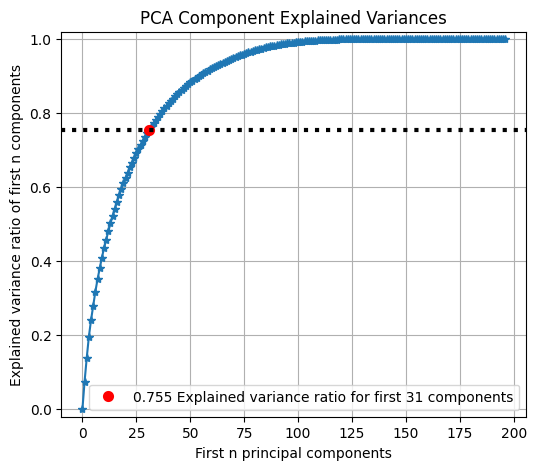

In [36]:
model = r
for c in range(0,25,5):
    print(f"PCA component #{c}: {sum(model['pca'].explained_variance_ratio_[0:c])*100:.0f}%")
plot_pca_component_variance(name=f"comp{c}", pca=model['pca'], save=False)

In [37]:
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": seed}

def plot_cluster_elbow(name, Y, save=False, figsize=(6,5)):
    skplt.cluster.plot_elbow_curve(KMeans(**kmeans_kwargs),
                               pd.DataFrame(data=Y),
                               cluster_ranges=range(1, 21, 1),
                               figsize=figsize)
    if save:
        plt.savefig(os.path.join(dir_fig, f"{name}_elbow.png"))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf60b1700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf60b1310>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf62300d0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf6088d30>
Traceback 

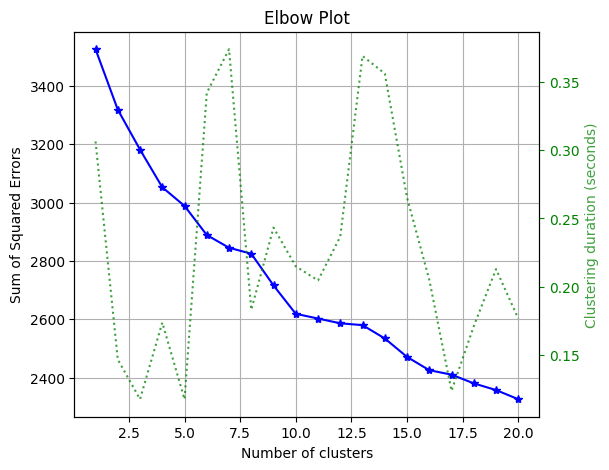

In [38]:
plot_cluster_elbow(name=f"comp{c}", Y=r['Y'], save=False)

In [39]:
# Y: each array represents a sequence, with each array value corresponding to a PCA component
# Y_df: dataframe where rows correspond to each sequence, and columns correspond to the PCA components
n_clusters = 6
Y_df = pd.DataFrame(data=r['Y'])

kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(Y_df)

labels = [str(c) for c in kmeans.predict(Y_df)] # length of threads dataframe
centroids = kmeans.cluster_centers_ # n_components

dfagg_per_thread['kmeans_cluster'] = labels # add the kmeans cluster label for each thread

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fab004b9820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fab004b9820>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faaf60b14c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fab004b9820>
Traceback 

In [40]:
dfagg_per_thread

,id,comment_pro_klimaat,sequence,kmeans_cluster
0,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
1,2,"[Nee, Ja, Nee, Ja, Ja]","[P, W, W, W, W]",3
2,3,"[Nee, Nee, Nee, Nee, Nee, Nee, Nee, Nee]","[q, y, P, y, y, y, y, y]",2
3,4,"[Ja, Ja, Ja, Ja, Ja, Ja, Ja]","[Q, W, Q, W, Q, W, W]",5
4,5,"[Nee, Ja, Ja, Nee, Ja, Nee]","[X, P, W, P, P, P]",1
...,...,...,...,...
344,589,"[Nee, Ja, Nee, Ja, Ja]","[I, P, W, P, I]",1
345,591,"[Nee, Ja, Ja, Nee, Ja, Neutraal, Ja]","[x, W, Q, W, W, W, W]",5
346,592,"[Nee, Ja, Nee, Neutraal, Nee, Neutraal]","[y, Y, y, y, r, y]",4
347,594,"[Ja, Nee, Ja, Ja, Ja]","[q, W, W, W, W]",3


In [41]:
# merge in tweet texts
dfagg_mettext = dfagg_per_thread.merge(tweets.rename({'tweet_id':'id'}, axis=1), on=['id'], how='left')
dfagg_mettext

,id,comment_pro_klimaat,sequence,kmeans_cluster,comment_nr,text
0,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1,0.0,Op basis van #CBS onderzoek blijkt dar 96 % va...
1,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1,1.0,@USER @USER @USER @USER Ja het wordt steeds ko...
2,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1,2.0,@USER @USER @USER @USER Omdat het steeds warme...
3,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1,3.0,@USER @USER @USER @USER Nou ik kan me niet her...
4,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1,4.0,@USER @USER @USER @USER Ik zou het huis maar e...
...,...,...,...,...,...,...
1675,595,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4,1.0,@USER https://t.co/wsq6qzESjV
1676,595,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4,2.0,@USER 🙄
1677,595,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4,3.0,@USER Triest hè. Maar goed een ouwe witte man.
1678,595,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4,4.0,@USER Supertriest. En ik ben te dom om dat te ...


In [42]:
dfagg_mettext[dfagg_mettext['kmeans_cluster']=='1'].to_excel('TEST.xlsx')

In [43]:
dfagg_per_thread.kmeans_cluster.value_counts()

kmeans_cluster
4    154
3     69
1     54
0     32
5     31
2      9
Name: count, dtype: int64

In [44]:
dfagg_per_thread

,id,comment_pro_klimaat,sequence,kmeans_cluster
0,1,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
1,2,"[Nee, Ja, Nee, Ja, Ja]","[P, W, W, W, W]",3
2,3,"[Nee, Nee, Nee, Nee, Nee, Nee, Nee, Nee]","[q, y, P, y, y, y, y, y]",2
3,4,"[Ja, Ja, Ja, Ja, Ja, Ja, Ja]","[Q, W, Q, W, Q, W, W]",5
4,5,"[Nee, Ja, Ja, Nee, Ja, Nee]","[X, P, W, P, P, P]",1
...,...,...,...,...
344,589,"[Nee, Ja, Nee, Ja, Ja]","[I, P, W, P, I]",1
345,591,"[Nee, Ja, Ja, Nee, Ja, Neutraal, Ja]","[x, W, Q, W, W, W, W]",5
346,592,"[Nee, Ja, Nee, Neutraal, Nee, Neutraal]","[y, Y, y, y, r, y]",4
347,594,"[Ja, Nee, Ja, Ja, Ja]","[q, W, W, W, W]",3


In [45]:
combined = dfagg.merge(dfagg_per_thread.rename({'id':'tweet_id'}, axis=1), on='tweet_id', suffixes=('','_thread'))
combined

,tweet_id,comment_nr,coder,comment_pro_klimaat,comment_inhoudelijk_argument,comment_persoonlijke_aanval,comment_over_communicatie,comment_respectvol,text,sequence,comment_pro_klimaat_thread,sequence_thread,kmeans_cluster
0,1,1,1252.083333,Neutraal,False,False,True,True,@USER @USER @USER @USER Ja het wordt steeds ko...,P,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
1,1,2,1252.083333,Ja,True,False,True,True,@USER @USER @USER @USER Omdat het steeds warme...,W,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
2,1,3,1252.083333,Nee,False,False,True,True,@USER @USER @USER @USER Nou ik kan me niet her...,P,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
3,1,4,1252.083333,Ja,True,True,True,True,@USER @USER @USER @USER Ik zou het huis maar e...,Q,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
4,1,5,1252.083333,Nee,False,True,True,False,@USER @USER @USER @USER Ja jij zat vast op Ibiza.,y,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,595,1,1161.380952,Nee,False,False,False,True,@USER https://t.co/wsq6qzESjV,X,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4
2000,595,2,1161.380952,Neutraal,False,False,True,False,@USER 🙄,p,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4
2001,595,3,1161.380952,Nee,False,True,True,False,@USER Triest hè. Maar goed een ouwe witte man.,y,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4
2002,595,4,1161.380952,Nee,False,True,True,False,@USER Supertriest. En ik ben te dom om dat te ...,y,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4


In [46]:
combined.groupby('comment_pro_klimaat')['kmeans_cluster'].value_counts()

comment_pro_klimaat  kmeans_cluster
Ja                   4                 223
                     3                 198
                     1                 142
                     0                 113
                     5                 106
                     2                  14
Nee                  4                 481
                     1                 117
                     3                 109
                     0                  45
                     2                  43
                     5                  39
Neutraal             4                 170
                     3                  70
                     1                  56
                     0                  36
                     5                  36
                     2                   6
Name: count, dtype: int64

<AxesSubplot:xlabel='comment_pro_klimaat', ylabel='count'>

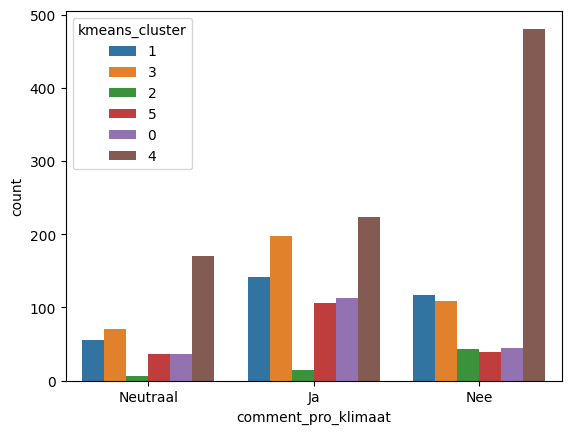

In [47]:
sns.countplot(x='comment_pro_klimaat', hue='kmeans_cluster', data=combined)

<AxesSubplot:xlabel='sequence', ylabel='count'>

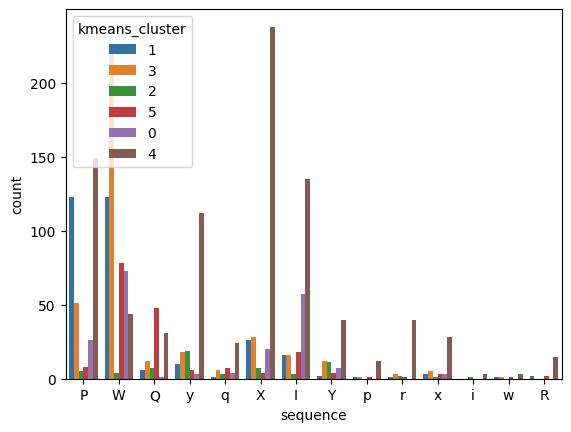

In [48]:
sns.countplot(x='sequence', hue='kmeans_cluster', data=combined)

In [49]:
combined

,tweet_id,comment_nr,coder,comment_pro_klimaat,comment_inhoudelijk_argument,comment_persoonlijke_aanval,comment_over_communicatie,comment_respectvol,text,sequence,comment_pro_klimaat_thread,sequence_thread,kmeans_cluster
0,1,1,1252.083333,Neutraal,False,False,True,True,@USER @USER @USER @USER Ja het wordt steeds ko...,P,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
1,1,2,1252.083333,Ja,True,False,True,True,@USER @USER @USER @USER Omdat het steeds warme...,W,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
2,1,3,1252.083333,Nee,False,False,True,True,@USER @USER @USER @USER Nou ik kan me niet her...,P,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
3,1,4,1252.083333,Ja,True,True,True,True,@USER @USER @USER @USER Ik zou het huis maar e...,Q,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
4,1,5,1252.083333,Nee,False,True,True,False,@USER @USER @USER @USER Ja jij zat vast op Ibiza.,y,"[Neutraal, Ja, Nee, Ja, Nee]","[P, W, P, Q, y]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,595,1,1161.380952,Nee,False,False,False,True,@USER https://t.co/wsq6qzESjV,X,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4
2000,595,2,1161.380952,Neutraal,False,False,True,False,@USER 🙄,p,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4
2001,595,3,1161.380952,Nee,False,True,True,False,@USER Triest hè. Maar goed een ouwe witte man.,y,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4
2002,595,4,1161.380952,Nee,False,True,True,False,@USER Supertriest. En ik ben te dom om dat te ...,y,"[Nee, Neutraal, Nee, Nee, Nee]","[X, p, y, y, y]",4


tweet_id
1           Persoonlijke aanval
2      Geen persoonlijke aanval
3           Persoonlijke aanval
4           Persoonlijke aanval
5      Geen persoonlijke aanval
                 ...           
589    Geen persoonlijke aanval
591         Persoonlijke aanval
592         Persoonlijke aanval
594         Persoonlijke aanval
595         Persoonlijke aanval
Name: comment_persoonlijke_aanval, Length: 349, dtype: object

# Create discussion-level varbiables


In [25]:
# is het hele gesprek alleen inhoudelijk en geen persoonlijke aanval?
gespreksniveau = pd.DataFrame(dfagg.groupby('tweet_id')['comment_inhoudelijk_argument'].min())
gespreksniveau.columns = ['helegesprekinhoudelijk']
gespreksniveau['helegesprekgeenpersoonlijkeaanval'] = dfagg.groupby('tweet_id')['comment_persoonlijke_aanval'].min()
gespreksniveau['issueframedgeprek'] = gespreksniveau['helegesprekgeenpersoonlijkeaanval'] * gespreksniveau['helegesprekinhoudelijk']
gespreksniveau['issueframedgeprek'] = gespreksniveau['issueframedgeprek'].map(bool)
gespreksniveau['helegesprekminimaaleendisrespect'] = dfagg.groupby('tweet_id')['comment_respectvol'].max()
gespreksniveau = gespreksniveau.reset_index()

gespreksniveau

TypeError: can't multiply sequence by non-int of type 'str'

In [51]:
# How many discussions relevant to our hypotheses are there at all?
print("Percentages:\n")
print(gespreksniveau.drop('tweet_id', axis=1).applymap(int).mean())
print('\n\n')
print("Absolute numbers:\n")
print(gespreksniveau.drop('tweet_id', axis=1).applymap(int).sum())

Percentages:

helegesprekinhoudelijk               0.094556
helegesprekgeenpersoonlijkeaanval    0.025788
issueframedgeprek                    0.000000
helegesprekminimaaleendisrespect     0.985673
dtype: float64



Absolute numbers:

helegesprekinhoudelijk                33
helegesprekgeenpersoonlijkeaanval      9
issueframedgeprek                      0
helegesprekminimaaleendisrespect     344
dtype: int64


In [52]:
gespr

NameError: name 'gespr' is not defined

In [ ]:
# SCRATCH BELOW

# H1 
H1: Interactions that include solely issue framing, polarize significantly less than interactions in which negative identity labels and/or process framing are present.

# TODO
waarschijnlijk is process framing verkeerd gecodeerd - zou bijna ooit Eens moeten zijn

In [ ]:
gespreksniveau.issueframedgeprek.value_counts()

In [ ]:
gespreksniveau.helegesprekgeenpersoonlijkeaanval.value_counts()

In [ ]:
gespreksniveau.helegesprekinhoudelijk.value_counts()

In [ ]:
gespreksniveau.helegesprekminimaaleendisrespect.value_counts()

In [ ]:
#issue_frame_interacties = dfagg.query("comment_inhoudelijk_argument=='Inhoudelijk argument' & comment_persoonlijke_aanval=='Geen persoonlijke aanval'" )
#issue_frame_interacties

In [ ]:
def gesprek_is_issue_only(series):
    return series.('Inhoudelijk argument')

In [ ]:
dfagg

In [ ]:
)

In [ ]:
inhoudelijkegesprekken = pd.DataFrame(test.groupby('tweet_id')['comment_inhoudelijk_argument_bool'].min())
# nee klopt niet, moet ook geen persoonlijke aanval
inhoudelijkegesprekken.columns=['inhoudelijkgesprek']
inhoudelijkegesprekken = inhoudelijkegesprekken.reset_index()

In [ ]:
test2 = test.merge(inhoudelijkegesprekken, on = 'tweet_id')
test2

In [ ]:
test2.inhoudelijkgesprek.value_counts()

In [ ]:
pd.crosstab(test2.inhoudelijkgesprek, test2.comment_respectvol)

In [ ]:
issue_frame_interacties.comment_respectvol.value_counts(normalize=True)

In [ ]:
rest = dfagg[~dfagg.index.isin(issue_frame_interacties.index)]
rest.comment_respectvol.value_counts(normalize=True)

In [ ]:
# nog heel veel te doen, mitsen maren ....
# maar: het is wel zou dat inhoudelijk + niet persoonlijk lijdt tot VEEL minder respectloze comments

# H2: Interactions that include negative identity labels, polarize significantly more often than interactions where these labels are not present.

In [ ]:
dfagg.groupby("comment_persoonlijke_aanval")['comment_respectvol']
